In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

import pysindy as ps

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $\mu$, $A$ fixed and $\omega$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ fixed, and $\omega \in [1,\pi]$.

In [2]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w' # help="name of the ode", type=str
ode_param = None # '1.,1.,1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/oscillatingVdpODE_par_w_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 100, 2) (50, 100, 2) (50, 100)
['X0', 'X1', 'X2']


In [3]:
# Uploda data:
file_path = 'saved/data/oscillatingVdpODE_par_w_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 100, 2) (50, 100, 2) (50, 100)
['X0', 'X1', 'X2']


Threshold:  0.01 , RMSE:  0.875905778350782
Threshold:  0.05 , RMSE:  0.8706499113947366
Threshold:  0.1 , RMSE:  0.8833546643258312
Threshold:  0.2 , RMSE:  1.016727185139964
Threshold:  0.4 , RMSE:  1.0876510514591993
Threshold:  0.6 , RMSE:  1.0876510514591993


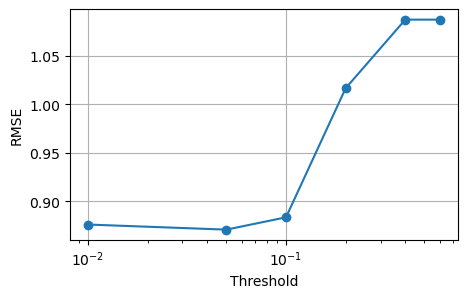

In [6]:
# Model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u = param_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [1., 1., np.pi], [0., 0., 1], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In [4]:
# Best model fit
model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.05))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u=param_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 1.059 1 + 1.212 X0 + -2.043 X1 + 0.394 X2 + -0.244 X0^2 + 0.198 X0 X1 + -0.074 X0 X2 + -0.226 X1^2 + 1.095 X1 X2 + -0.488 X2^2 + 0.082 X0^2 X2 + -1.009 X0 X1^2 + -0.064 X0 X1 X2 + -0.250 X1 X2^2 + 0.097 X2^3
(X1)' = 1.000 X0


### Plot per report

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t[:T_plot],
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t[:T_plot]
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]

    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$t$")
            ax.set_ylabel(r"$x(t)$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9, frameon=False, loc='lower right')

            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 (PHASE SPACE) ----------
        elif dim_x == 2:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4.3))

            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$x_1$")
            ax.set_ylabel(r"$x_2$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(
            fontsize=9,
            loc='lower right',
            frameon=True,
            framealpha=0.8,
            facecolor='white',
            edgecolor='0.8'
            )


            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.set_zlabel(r"$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()


Best Model RMSE:  0.8400823826290365


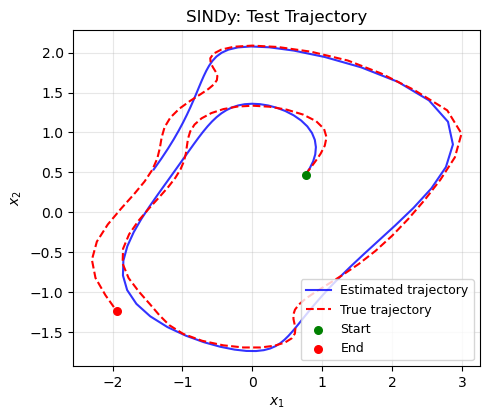

In [6]:
# Evaluation: within the training -> RMSE and reconstruction
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1., np.pi], [0., 0., 1], dim_k)
print('Best Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'SINDy: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 10)

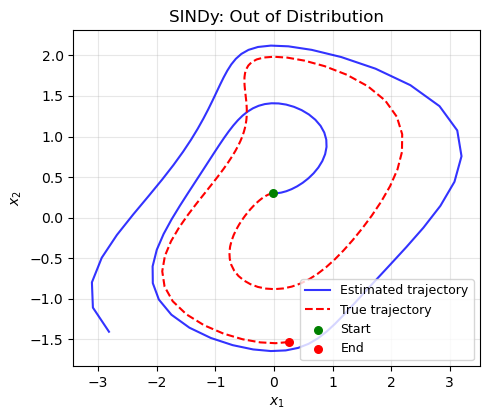

In [7]:
# Evaluation: within the training -> RMSE and reconstruction
evaluate_sample = 1
ics = [0.0, 0.3, 0.8]
title = 'SINDy: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 10)

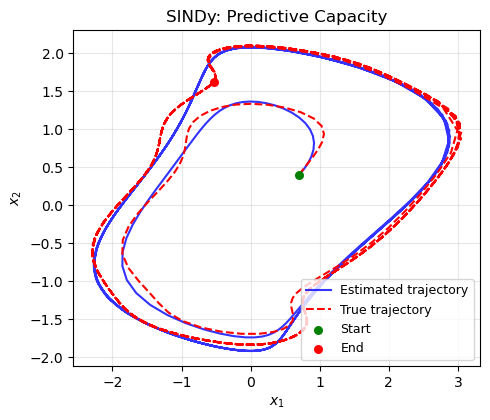

In [8]:
evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'SINDy: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 40)